In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
import array_to_latex as a2l
import csv
import pandas as pd
from astropy.io.votable import parse
from astropy.table import QTable, Table, Column

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}) #font na grafih je LaTexov
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{siunitx}')

In [3]:
def linearna(x, k, n): 
    return k*x + n 


def f(T, n):
    E = 1.1 * 1.6022e-19
    k_b = 1.3807e-23
    y = E / (k_b * T)
    return n * (1 - (15 / (np.pi**4)) * ( - y**3 * np.log(1 - np.exp(-y)) + np.exp(-y) * (3 * y ** 2 + 6 * y + 6)))

In [4]:
data_air = np.array(pd.read_csv('meas_air.csv', delimiter=';'))
data_si = np.array(pd.read_csv('meas_si.csv', delimiter=';'))

# indeks z - zarnica (moč, tok, napetost), indeks s - senzor

Pz_air = data_air[:, 0]
Iz_air = data_air[:, 1]
Uz_air = data_air[:, 2]
Ps_air = data_air[:, 3]

Pz_si = data_si[:, 0]
Iz_si = data_si[:, 1]
Uz_si = data_si[:, 2]
Ps_si = data_si[:, 3]

Ps_air = unp.uarray(Ps_air, 15*[0.5e-6])
Ps_si = unp.uarray(Ps_si, 15*[0.5e-6])

In [5]:
#konstante 

R0 = unp.uarray([123.4], [0.1])
d = unp.uarray([74e-2], [1e-2])

sigma = 5.6704e-8
k = 1.3807e-23

Tz = unp.uarray([2700], [100])

q_0 = 1.6022e-19
E_0 = 1.1 * q_0


In [6]:
prost_kot = 1e-4 / (d ** 2)

Ps_air_p = 1 / prost_kot * Ps_air

Ps_si_p = (1 / prost_kot) * Ps_si

k_air, _ = curve_fit(linearna, unp.nominal_values(Pz_air), unp.nominal_values(Ps_air_p))

k_si, _ = curve_fit(linearna, unp.nominal_values(Pz_si), unp.nominal_values(Ps_si_p))

Ps_si_p

array([0.90354+/-0.024573014548483874, 0.783068+/-0.021340373473770324,
       0.76664+/-0.02090012066950811,
       0.7173560000000001+/-0.01958037762659342,
       0.668072+/-0.018262414407739194, 0.607836+/-0.01665460380795653,
       0.5432192+/-0.014934725392855407, 0.4594364+/-0.012715482682147778,
       0.4276756+/-0.011878657392146642, 0.3636064+/-0.010201495176688563,
       0.29734679999999997+/-0.008490015839796769,
       0.2261588+/-0.006697617319614492,
       0.1812556+/-0.0056120304204449935,
       0.1106152+/-0.004053930458209662, 0.062974+/-0.003223887094797211],
      dtype=object)

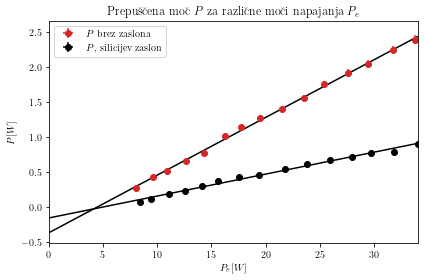

In [7]:
fig, ax = plt.subplots()

ax.errorbar(unp.nominal_values(Pz_air), unp.nominal_values(Ps_air_p), yerr=unp.std_devs(Ps_air_p), xerr=unp.std_devs(Pz_air), color='tab:red', linestyle='none', marker='o', label=r'$P$ brez zaslona')
ax.errorbar(unp.nominal_values(Pz_si), unp.nominal_values(Ps_si_p), yerr=unp.std_devs(Ps_si_p), xerr=unp.std_devs(Pz_si), color='k', linestyle='none', marker='o', label=r'$P$, silicijev zaslon')

Pz_lin = np.linspace(0, 35)

ax.plot(Pz_lin, linearna(Pz_lin, *k_air), color='k', zorder=-1)
ax.plot(Pz_lin, linearna(Pz_lin, *k_si), color='k', zorder=-1)

ax.set_title(r'Prepuščena moč $P$ za različne moči napajanja $P_e$')
ax.set_xlabel(r'$P_e [W]$')
ax.set_ylabel(r'$P [W]$')
ax.set_xlim(0, 34)
ax.legend()
fig.tight_layout()
fig.savefig('PPe.pdf')

In [8]:
# upornost žice glede na temperaturo
Rz = Uz_air / Iz_air

# račun za površino žarilne nitke, ki jo izračunamo preko Stefanovega zakona pri polni moči in temperaturi 2700K

P_0 = Ps_air[0]

S  = P_0 / (sigma * Tz ** 4)

# s površino žarilne nitke lahko sedaj izračunamo preostale temperature glede na izmerjene moči


T_air = (Ps_air / (S * sigma)) ** (1 / 4)
T_si = (Pz_si / Pz_air) ** (1 / 4) * T_air

par, cov = curve_fit(linearna, unp.nominal_values(T_air), unp.nominal_values(Rz))

par, np.sqrt(np.diag(cov))


(array([  0.54704438, 213.56821632]), array([1.47601704e-02, 3.35100401e+01]))

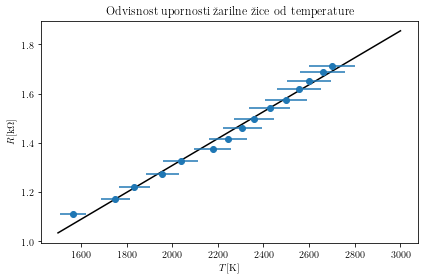

In [9]:
fig, ax = plt.subplots()

ax.errorbar(unp.nominal_values(T_air), 1e-3 * unp.nominal_values(Rz), xerr=unp.std_devs(T_air), yerr=unp.std_devs(Rz), linestyle='', marker='o', color='tab:blue')

# temperature se raztezajo od 1565 do 2700: 

T_lin = np.linspace(1500, 3000)

ax.plot(T_lin, 1e-3 * linearna(T_lin, *par), color='k', zorder=-1)

ax.set_title('Odvisnost upornosti žarilne žice od temperature')
ax.set_xlabel(r'$T [\si{K}]$')
ax.set_ylabel(r'$R [\si{k\Omega}]$')

fig.tight_layout()
fig.savefig('RT.pdf')

In [10]:
#povp. temperature med zrakom in si za vse meritve

povp_T = (T_air + T_si) / 2

# razmerje tokov

t = Ps_si / Ps_air
print(t)

# regresija podatkov razmerja med prepuščenim in nemotenim svetlobnim tokom kot funkcijo temperature žarilne nitke


par, cov = curve_fit(f, unp.nominal_values(povp_T), unp.nominal_values(t[::-1]))


eta  = par
sigma_eta  = np.sqrt(np.diag(cov))

eta = unp.uarray(eta, sigma_eta)


n = 1 / eta + unp.sqrt(1 / (eta ** 2) -1)
eta, n

[0.3793103448275862+/-0.0012293351105248373
 0.34963325183374083+/-0.0012950610099804612
 0.3753351206434316+/-0.0014317938109500389
 0.3753581661891118+/-0.0015302668787345005
 0.3824451410658307+/-0.0016781149325719848
 0.3908450704225352+/-0.0018902580175198423
 0.3905511811023622+/-0.002113306308663359
 0.3616379310344828+/-0.0022917722765167826
 0.3754807692307693+/-0.0025677148374197946
 0.36086956521739133+/-0.0028889165052671134
 0.38510638297872335+/-0.0037999675141549964
 0.3441666666666667+/-0.004406534554335116
 0.35668103448275856+/-0.005720403096391366
 0.2623376623376623+/-0.006713233888200139
 0.23373983739837398+/-0.010436523368352041]


(array([0.42848026671142225+/-0.011995744569550632], dtype=object),
 array([4.442564306983037+/-0.13765036558114555], dtype=object))

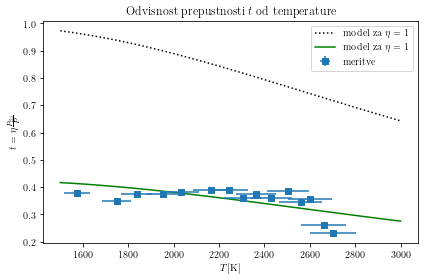

In [11]:
fig, ax = plt.subplots()

ax.errorbar(unp.nominal_values(povp_T), unp.nominal_values(t[::-1]), xerr=unp.std_devs(povp_T), yerr=unp.std_devs(t), label='meritve', fmt='s')

T_lin = np.linspace(1500, 3000)

ax.plot(T_lin, f(T_lin, 1), color='k', linestyle=':', zorder=-1, label=r'model za $\eta = 1$')
ax.plot(T_lin, f(T_lin, *par), color='g', zorder=-1, label=r'model za $\eta = 1$')


ax.set_title(r'Odvisnost prepustnosti $t$ od temperature')
ax.set_xlabel(r'$T [\si{K}]$')
ax.set_ylabel(r'$t = \eta \frac{P_{\si{Si}}}{P}$')
ax.legend()

fig.tight_layout()
fig.savefig('tT.pdf')